# PCA

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error

In [2]:
# Import dataframe (without upper 1% of prices and without lat, lon column
dataframe = pd.read_csv("CurrentData/listings_drop_final.csv")

In [3]:
# Split data into train and test blocks
random_state = 42

df_tr, df_test = train_test_split(dataframe, test_size = 0.2, random_state = random_state, shuffle = True)
df_train, df_validation = train_test_split(df_tr, test_size = 0.2, random_state = random_state, shuffle = True)

# Split into features and target
def split_dataframe_Xy(df_train, df_validation, df_test):
    # Split dataframe into features and target
    X_train = df_train.drop(columns = ["price"])
    y_train = df_train["price"] # Note: is now a pandas series, not a dataframe
    X_validation = df_validation.drop(columns = ["price"])
    y_validation = df_validation["price"] # Note: -//-
    X_test = df_test.drop(columns = ["price"])
    y_test = df_test["price"] # Note: -//-

    return X_train, y_train, X_validation, y_validation, X_test, y_test

X_train, y_train, X_validation, y_validation, X_test, y_test = split_dataframe_Xy(df_train, df_validation, df_test)

# Keep train+val combined for later 
# NOT USED SO FAR
X_tr = df_tr.drop(columns = ["price"])
y_tr = df_tr["price"] # Note: is now a pandas series, not a dataframe

In [4]:
print(X_train.shape)

(5637, 299)


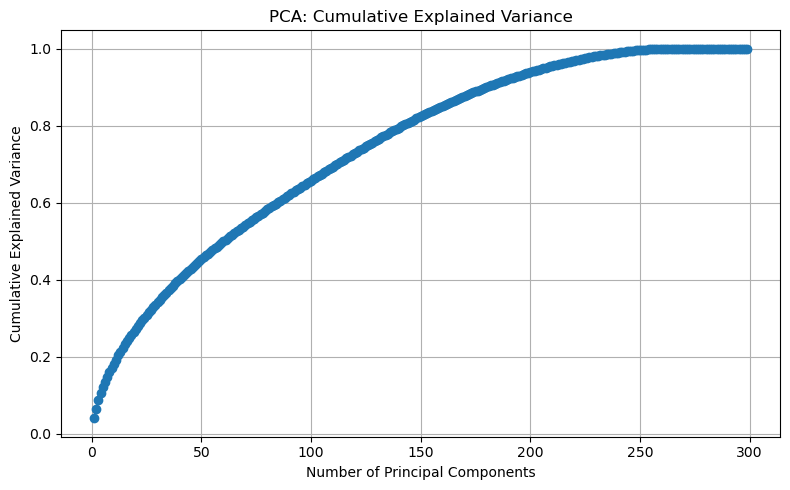

Number of components to retain 95% variance: 207
Number of components to retain 98% variance: 229
Number of components to retain 99% variance: 240
Number of components to retain 100% variance: 271


In [5]:
# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

# Explained variance plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker = 'o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Check number of components to retain x% variance
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
print(f"Number of components to retain 95% variance: {n_components_95}")
n_components_98 = (cumulative_variance >= 0.98).argmax() + 1
print(f"Number of components to retain 98% variance: {n_components_98}")
n_components_99 = (cumulative_variance >= 0.99).argmax() + 1
print(f"Number of components to retain 99% variance: {n_components_99}")
n_components_100 = (cumulative_variance >= 1.0).argmax() + 1
print(f"Number of components to retain 100% variance: {n_components_100}")

#### It seems that the "last" 28 PCA-feature-combinations basically do not cause any of the variance and 240 principal components explain 99% of the variance.

In [6]:
# Re-fit PCA with chosen number of components
pca_reduced = PCA(n_components=n_components_99)
X_train_pca = pca_reduced.fit_transform(X_train_scaled)

In [7]:
# Apply PCA transformation
X_validation_pca = pca_reduced.transform(X_validation_scaled)
X_test_pca = pca_reduced.transform(X_test_scaled)

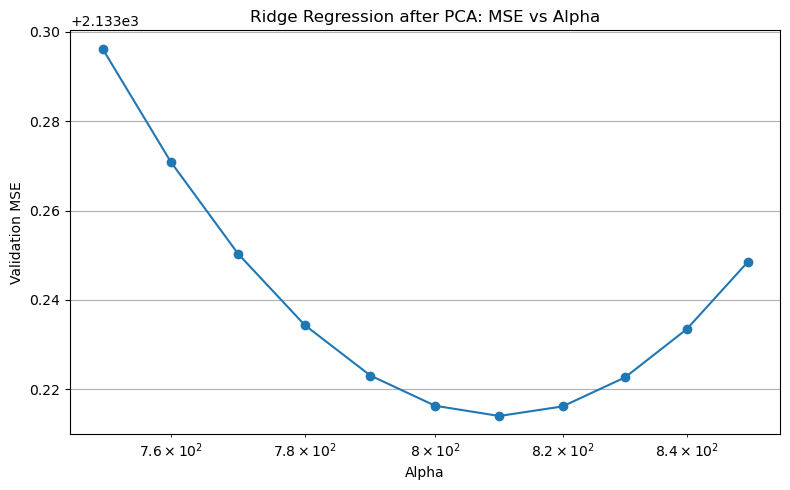

In [8]:
tupel_list = [(X_train_pca, y_train, X_validation_pca, y_validation, X_test_pca, y_test)]

for tuple in tupel_list:
    
    X_train_scaled, y_train, X_validation_scaled, y_validation, X_test_scaled, y_test = tuple

    # List of alphas to try
    alphas = [        
        750,
        760,
        770,
        780,
        790,
        800,
        810,
        820,
        830,
        840,
        850,

    ]

    ridge_mse_results = []
    
    for alpha in alphas:
        model = Ridge(alpha = alpha)
        model.fit(X_train_scaled, y_train)

        y_val_pred = model.predict(X_validation_scaled)

        mse_val = mean_squared_error(y_validation, y_val_pred)

        ridge_mse_results.append((alpha, mse_val))


    # Plot the results
    alphas_plot, mses_plot = zip(*ridge_mse_results)  # Unpack tuples

    plt.figure(figsize=(8, 5))
    plt.plot(alphas_plot, mses_plot, marker = "o")
    plt.xscale("log")  # Log scale for better visualization
    plt.xlabel("Alpha")
    plt.ylabel("Validation MSE")
    plt.title(f"Ridge Regression after PCA: MSE vs Alpha")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### -> alpha = 810 is ideal

## Test this model on the test set

In [11]:
model = Ridge(alpha = 810)
model.fit(X_train_pca, y_train)

# Predict and evaluate
y_val_pred = model.predict(X_validation_pca)
y_test_pred = model.predict(X_test_pca)

mse_val = mean_squared_error(y_validation, y_val_pred)
mse = mean_squared_error(y_test, y_test_pred)

print("Validation MSE:", mse_val)
print("Test MSE:", mse)

rmse = mse ** 0.5
print(f"RMSE: {rmse:.2f}")

mar = mean_absolute_error(y_test, y_test_pred)
print(f"Mean absolute error: {mar:.2f}")

# Mean Relative Error
relative_errors = np.abs((y_test_pred - y_test) / y_test)
mre_p = np.mean(relative_errors) * 100
print(f"Mean Relative Error (MRE): {mre_p:.1f}%")

Validation MSE: 2133.2140661528647
Test MSE: 2102.038723241385
RMSE: 45.85
Mean absolute error: 32.64
Mean Relative Error (MRE): 36.1%


## MSE for listings_drop_final after PCA: 2102

## Conclusion
<div style="font-size: 1.2em; font-weight: 500;">
We can reduce the dimensionality of our problem from 300 to 240 while barely sacrificing performance in terms of MSE 
(MSE on the test set drops from about 2060 to about 2100).<br>
This might imply some colinearity in our original features, which makes sense, since, for exmpale, all one-hot encoded groups have one (often) colinear feature. <br>
We might not really need this dimensionality reduction, but for bigger problems or data it might become relevant for e.g. computational speed.
</div>